### Comparing Aggregate Models for Regression

This try-it focuses on utilizing ensemble models in a regression setting.  Much like you have used individual classification estimators to form an ensemble of estimators -- here your goal is to explore ensembles for regression models.  As with your earlier assignment, you will use scikitlearn to carry out the ensembles using the `VotingRegressor`.   


#### Dataset and Task

Below, a dataset containing census information on individuals and their hourly wage is loaded using the `fetch_openml` function.  OpenML is another repository for datasets [here](https://www.openml.org/).  Your task is to use ensemble methods to explore predicting the `wage` column of the data.  Your ensemble should at the very least consider the following models:

- `LinearRegression` -- perhaps you even want the `TransformedTargetRegressor` here.
- `KNeighborsRegressor`
- `DecisionTreeRegressor`
- `Ridge`
- `SVR`

Tune the `VotingRegressor` to try to optimize the prediction performance and determine if the wisdom of the crowd performed better in this setting than any of the individual models themselves.  Report back on your findings and discuss the interpretability of your findings.  Is there a way to determine what features mattered in predicting wages?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml

In [104]:
survey = fetch_openml(data_id=534, as_frame=True).frame

In [105]:
survey.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


In [106]:
survey.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   WAGE        534 non-null    float64 
 6   AGE         534 non-null    int64   
 7   RACE        534 non-null    category
 8   OCCUPATION  534 non-null    category
 9   SECTOR      534 non-null    category
 10  MARR        534 non-null    category
dtypes: category(7), float64(1), int64(3)
memory usage: 21.4 KB


<Axes: >

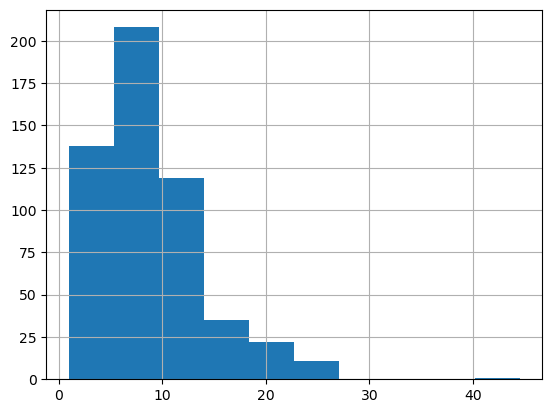

In [125]:
# show the distribution of the target variable
survey['WAGE'].hist()

In [133]:
# set up the linear regression, knn, decision tree, ridge, and svr models for the ensemble
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor

lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
ridge = Ridge()
svr = SVR()
# ttr = TransformedTargetRegressor(regressor=svr, func=np.log1p, inverse_func=np.expm1)

models = [('lr', lr), ('knn', knn), ('dt', dt), ('ridge', ridge), ('svr', svr)]

# create a dataframe to hold the results
results_df = pd.DataFrame(columns=['model', 'MSE', 'R2', 'fit_time'])



In [134]:
# set up the voting regressor

voting = VotingRegressor(estimators=[('lr', lr), ('knn', knn), ('dt', dt), ('ridge', ridge), ('svr', svr)])

# set up the pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

X = survey.drop(columns='WAGE')
y = survey['WAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [135]:
# set up the column transformer
categorical = X.select_dtypes(include=['category']).columns
numerical = X.select_dtypes(exclude=['category']).columns
print(categorical)
print(numerical)

#import StandardScaler
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(), categorical)
    ]
)

Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object')
Index(['EDUCATION', 'EXPERIENCE', 'AGE'], dtype='object')


In [136]:
# Fit the preprocessor
preprocessor.fit(X)

# Get the names of the transformed features
transformed_columns = preprocessor.get_feature_names_out()
print(len(transformed_columns))
transformed_columns

23


array(['num__EDUCATION', 'num__EXPERIENCE', 'num__AGE', 'cat__SOUTH_no',
       'cat__SOUTH_yes', 'cat__SEX_female', 'cat__SEX_male',
       'cat__UNION_member', 'cat__UNION_not_member', 'cat__RACE_Hispanic',
       'cat__RACE_Other', 'cat__RACE_White', 'cat__OCCUPATION_Clerical',
       'cat__OCCUPATION_Management', 'cat__OCCUPATION_Other',
       'cat__OCCUPATION_Professional', 'cat__OCCUPATION_Sales',
       'cat__OCCUPATION_Service', 'cat__SECTOR_Construction',
       'cat__SECTOR_Manufacturing', 'cat__SECTOR_Other',
       'cat__MARR_Married', 'cat__MARR_Unmarried'], dtype=object)

In [137]:
results_df

,model,MSE,R2,fit_time


## Single model evaluation - default parameters

In [138]:
# populate the results dataframe with the output from the individual models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time

for m in models:
    name = m[0]
    model = m[1]
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
    start = time.time()
    pipe.fit(X_train, y_train)
    end = time.time()
    mse = mean_squared_error(y_test, pipe.predict(X_test))
    r2 = r2_score(y_test, pipe.predict(X_test))

    fit_time = end - start
    # update the dataframe with the results
    next_index = len(results_df)
    results_df.loc[next_index] = [name, mse, r2, fit_time]
    
    print(f'{model} MSE: {mse:.2f}')
    print(f'{model} R2: {r2:.2f}')
    print(f'{model} fit time: {fit_time:.2f}')

    print('\n')
    

LinearRegression() MSE: 19.50
LinearRegression() R2: 0.39
LinearRegression() fit time: 0.01


KNeighborsRegressor() MSE: 19.77
KNeighborsRegressor() R2: 0.38
KNeighborsRegressor() fit time: 0.01


DecisionTreeRegressor() MSE: 51.07
DecisionTreeRegressor() R2: -0.60
DecisionTreeRegressor() fit time: 0.01


Ridge() MSE: 19.50
Ridge() R2: 0.39
Ridge() fit time: 0.02


SVR() MSE: 20.98
SVR() R2: 0.34
SVR() fit time: 0.03




In [139]:
results_df

,model,MSE,R2,fit_time
0,lr,19.502597,0.388221,0.011566
1,knn,19.771631,0.379782,0.007501
2,dt,51.072268,-0.602091,0.005852
3,ridge,19.504598,0.388158,0.020307
4,svr,20.983530,0.341766,0.028760


## Single model voting

In [140]:
# set up the pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('voting', voting)
])

# fit the model
pipe.fit(X_train, y_train)

# evaluate the model
from sklearn.metrics import mean_squared_error

start = time.time()
y_pred = pipe.predict(X_test)
end = time.time()
fit_time = end - start

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}')

# add the voting regressor to the results dataframe
results_df.loc[len(results_df)] = ['voting', mse, r2, fit_time]

         

MSE: 20.005514827841793


In [ ]:
results_df


,model,MSE,R2,fit_time
0,lr,19.502597,0.388221,0.011566
1,knn,19.771631,0.379782,0.007501
2,dt,51.072268,-0.602091,0.005852
3,ridge,19.504598,0.388158,0.020307
4,svr,20.983530,0.341766,0.028760
5,voting,20.005515,0.372445,0.183893


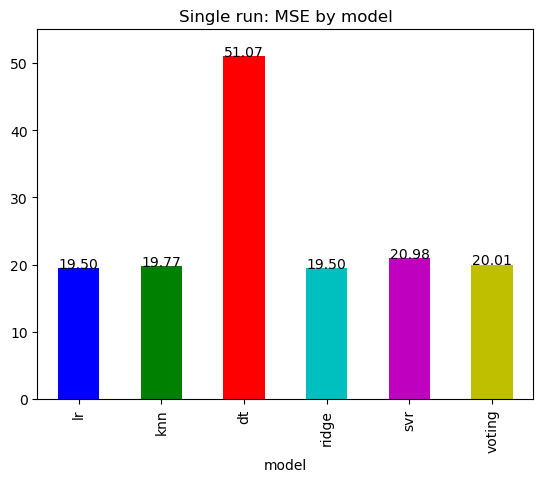

In [188]:
# plot the results
# set up the colors for the different models
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# plot the MSE
results_df.plot(x='model', y='MSE', kind='bar', title='Single run: MSE by model', color=colors)
# add the actual values to the plot
for i, v in enumerate(results_df['MSE']):
    plt.text(i, v, f'{v:.2f}', color='black', ha='center')
# suppress the legend
plt.gca().get_legend().remove()
plt.ylim(0, 55)
plt.savefig('./images/mse_1run.png')
plt.show()


## Grid Searches for each model

In [116]:
## Grid Search for best hyperparameters for each model
from sklearn.model_selection import GridSearchCV

# set the hyperparameters for the linear regression model
lr_params = {
    'model__fit_intercept': [True]
}

# set the hyperparameters for the knn model
knn_params = {
    'model__n_neighbors': [1, 3, 5, 7, 9],
    'model__weights': ['uniform', 'distance']
}

# set the hyperparameters for the decision tree model
dt_params = {
    'model__max_depth': [2, 5, 10, 20],
    'model__min_samples_split': [2, 4, 6]
}

# set the hyperparameters for the ridge model
ridge_params = {
    'model__alpha': [0.1, 1, 10],
    'model__fit_intercept': [True, False]
}

# set the hyperparameters for the svr model
svr_params = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'poly', 'rbf']
}

# # set the hyperparameters for the ttr model
# ttr_params = {
#     'model__regressor__C': [0.1, 1, 10],
#     'model__regressor__kernel': ['linear', 'poly', 'rbf']
# }

# set the hyperparameters for the voting regressor
voting_params = {
    'voting__weights': [(w1, w2, w3, w4, w5) for w1 in range(1, 6) for w2 in range(1, 6) for w3 in range(1, 6) for w4 in range(1, 6) for w5 in range(1, 6)]
}



In [117]:

# create a new dataframe to hold the results
results_df2 = pd.DataFrame(columns=['model', 'MSE', 'R2', 'fit_time'])
grids = []


## Run the Grid Searches and store the results

In [ ]:


for model in models:
    name = model[0]
    model = model[1]
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
    grid = GridSearchCV(pipe, eval(f'{name}_params'), n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    y_pred = grid.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    fit_time = grid.refit_time_
    model = grid.best_estimator_.named_steps['model']
    name = model.__class__.__name__

    results_df2.loc[len(results_df2)] = [name, mse, r2, fit_time]
    grids.append(grid)
    
    print(f'{model} MSE: {mse:.2f}')


{'model__fit_intercept': True}
LinearRegression() MSE: 19.50
{'model__n_neighbors': 9, 'model__weights': 'uniform'}
KNeighborsRegressor(n_neighbors=9) MSE: 20.87
{'model__max_depth': 2, 'model__min_samples_split': 2}
DecisionTreeRegressor(max_depth=2) MSE: 22.71
{'model__alpha': 10, 'model__fit_intercept': True}
Ridge(alpha=10) MSE: 19.68
{'model__C': 1, 'model__kernel': 'linear'}
SVR(C=1, kernel='linear') MSE: 21.70


In [119]:

results_df2


,model,MSE,R2,fit_time
0,LinearRegression,19.502597,0.388221,0.015548
1,KNeighborsRegressor,20.867631,0.345401,0.006549
2,DecisionTreeRegressor,22.714052,0.287481,0.007815
3,Ridge,19.679409,0.382675,0.010754
4,SVR,21.701280,0.319251,0.027742


In [120]:
# show the improvement from results_df to results_df2
results_df2['improvement'] = results_df['MSE'] - results_df2['MSE']
results_df2

,model,MSE,R2,fit_time,improvement
0,LinearRegression,19.502597,0.388221,0.015548,0.000000
1,KNeighborsRegressor,20.867631,0.345401,0.006549,-1.096000
2,DecisionTreeRegressor,22.714052,0.287481,0.007815,12.611606
3,Ridge,19.679409,0.382675,0.010754,-0.174812
4,SVR,21.701280,0.319251,0.027742,-0.717750


## Grid Search for the best weighting for the voting

In [179]:
# set up the voting regressor using the best models from the grid search
lr = grids[0].best_estimator_.named_steps['model']
knn = grids[1].best_estimator_.named_steps['model']
dt = grids[2].best_estimator_.named_steps['model']
ridge = grids[3].best_estimator_.named_steps['model']
svr = grids[4].best_estimator_.named_steps['model']

voting2 = VotingRegressor(estimators=[('lr', lr), ('knn', knn), ('dt', dt), ('ridge', ridge), ('svr', svr)])

# set up the grid search for the voting regressor
vote_pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('voting', voting2)])
grid = GridSearchCV(vote_pipe2, voting_params, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print(grid.best_params_)

y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
fit_time = grid.refit_time_
model = grid.best_estimator_.named_steps['voting']
name = model.__class__.__name__


{'voting__weights': (1, 5, 5, 5, 5)}


In [180]:
improvement = results_df['MSE'].iloc[-1] - mse
results_df2.loc[len(results_df2)] = [name, mse, r2, fit_time, improvement]
print(f'{name} MSE: {mse:.2f}')


VotingRegressor MSE: 19.98


In [181]:
results_df2

,model,MSE,R2,fit_time,improvement
0,LinearRegression,19.502597,0.388221,0.015548,0.000000
1,KNeighborsRegressor,20.867631,0.345401,0.006549,-1.096000
2,DecisionTreeRegressor,22.714052,0.287481,0.007815,12.611606
3,Ridge,19.679409,0.382675,0.010754,-0.174812
4,SVR,21.701280,0.319251,0.027742,-0.717750
6,VotingRegressor,19.981856,0.373187,0.054120,0.023658


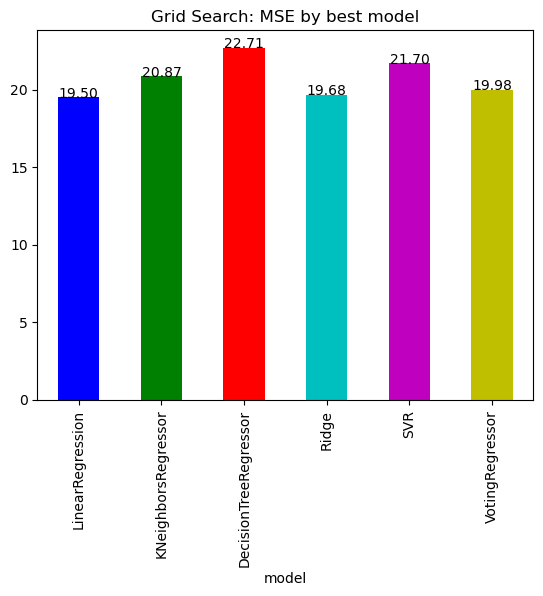

In [189]:
# plot the results
# set up the colors for the different models
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

results_df2.plot(x='model', y='MSE', kind='bar', title='Grid Search: MSE by best model', color=colors)
# add the actual values to the plot
for i, v in enumerate(results_df2['MSE']):
    plt.text(i, v, f'{v:.2f}', color='black', ha='center')

# suppress the legend
plt.gca().get_legend().remove()
plt.savefig('./images/mse_gridrun.png')

plt.show()

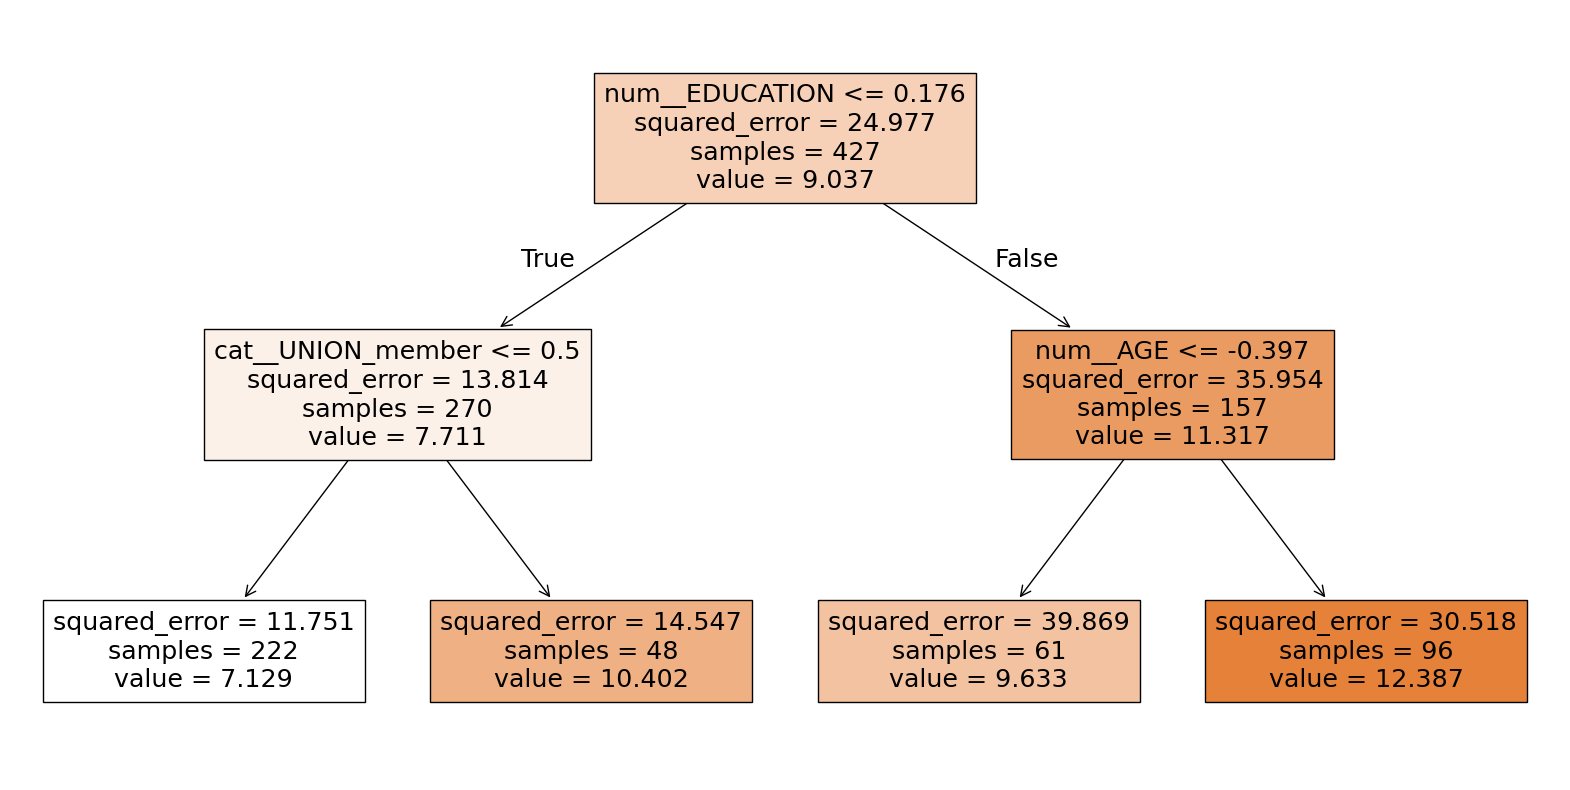

In [173]:
# show the decision tree
from sklearn.tree import plot_tree

dt = grids[2].best_estimator_.named_steps['model']
plt.figure(figsize=(20, 10))

plot_tree(dt, filled=True, feature_names=transformed_columns)
plt.savefig('./images/decision_tree.png')
plt.show()


## Explore the feature contributions

In [94]:
color_map = {
    'AGE': 'red',
    'EXPERIENCE': 'blue',
    'EDUCATION': 'green',
    'OCCUPATION': 'purple',
    'UNION': 'orange',
    'SEX': 'brown',
    'SECTOR': 'pink',
    'RACE': 'gray',
    'SOUTH': 'olive',
    'MARR': 'cyan'
}
features = transformed_columns

def extract_original_feature(transformed_feature_name):
    # Split the string at underscores
    parts = transformed_feature_name.split('__')
    
    # Return the middle part, which is assumed to be the original feature name
    if len(parts) > 1:
        parts2 = parts[1].split('_')
        if len(parts2) > 1:
            name = parts2[0]
        else:
            name = parts[1]
    else:
        # If there's no double underscore, return the whole string or handle it as needed
        name = transformed_feature_name

    return name
    
# Apply the function to the list of features
original_features = [extract_original_feature(feature) for feature in features]
    
# Create a list of colors based on the feature names
# Derive the original feature name from the transformed feature name
original_colors = [color_map[feature] for feature in original_features]

# show the mapping of transformed features to original colors
for i, feature in enumerate(features):
    print(f'{feature}: {original_colors[i]}')

num__AGE: red
num__EXPERIENCE: blue
num__EDUCATION: green
cat__SECTOR_Manufacturing: pink
cat__OCCUPATION_Service: purple
cat__SECTOR_Other: pink
cat__RACE_Hispanic: gray
cat__MARR_Unmarried: cyan
cat__SEX_female: brown
cat__OCCUPATION_Professional: purple
cat__OCCUPATION_Sales: purple
cat__SEX_male: brown
cat__OCCUPATION_Clerical: purple
cat__RACE_Other: gray
cat__OCCUPATION_Other: purple
cat__SECTOR_Construction: pink
cat__UNION_member: orange
cat__SOUTH_yes: olive
cat__RACE_White: gray
cat__UNION_not_member: orange
cat__SOUTH_no: olive
cat__MARR_Married: cyan
cat__OCCUPATION_Management: purple


In [176]:
# Function to normalize feature importances
def normalize_importances(importances):
    return importances / np.sum(importances)

# get the weights of the models
weights = grid.best_estimator_.named_steps['voting'].weights
print(weights)

# Extract and aggregate feature importances
feature_importances = np.zeros(len(transformed_columns))
count_models_contributing = 0
i = 0
contributing_shares = 0 
for name, reg in voting.estimators:
    if hasattr(reg, 'feature_importances_'):
        # Normalize and add tree-based importances
        print(f"{name} has feature importances with shape: {reg.feature_importances_.shape}")
        count_models_contributing += 1
        contributing_shares += weights[i]
        feature_importances += weights[i] * normalize_importances(reg.feature_importances_)
    elif hasattr(reg, 'coef_'):
        # Normalize and add linear model coefficients
        print(f"{name} has coefficients with shape: {reg.coef_.shape}")
        count_models_contributing += 1
        contributing_shares += weights[i]
        feature_importances += weights[i] * normalize_importances(np.abs(reg.coef_))
    else:
        print(f"{name} has no feature importances or coefficients")

    i += 1

# Average the feature importances
feature_importances /= contributing_shares

# Display the feature importances
print("Feature Importances:", feature_importances)
print("Number of models contributing:", count_models_contributing)
print("Contributing shares:", contributing_shares)

(1, 5, 5, 5, 5)
lr has coefficients with shape: (23,)
knn has no feature importances or coefficients
dt has feature importances with shape: (23,)
ridge has coefficients with shape: (23,)
svr has no feature importances or coefficients
Feature Importances: [0.13570486 0.15314026 0.10155574 0.01482482 0.02325945 0.03740478
 0.03429624 0.05295232 0.03806937 0.0203408  0.01793779 0.0220959
 0.02968985 0.09301863 0.0235303  0.03832946 0.03445897 0.05404998
 0.00436603 0.03405756 0.01967154 0.00997949 0.00726586]
Number of models contributing: 3
Contributing shares: 11


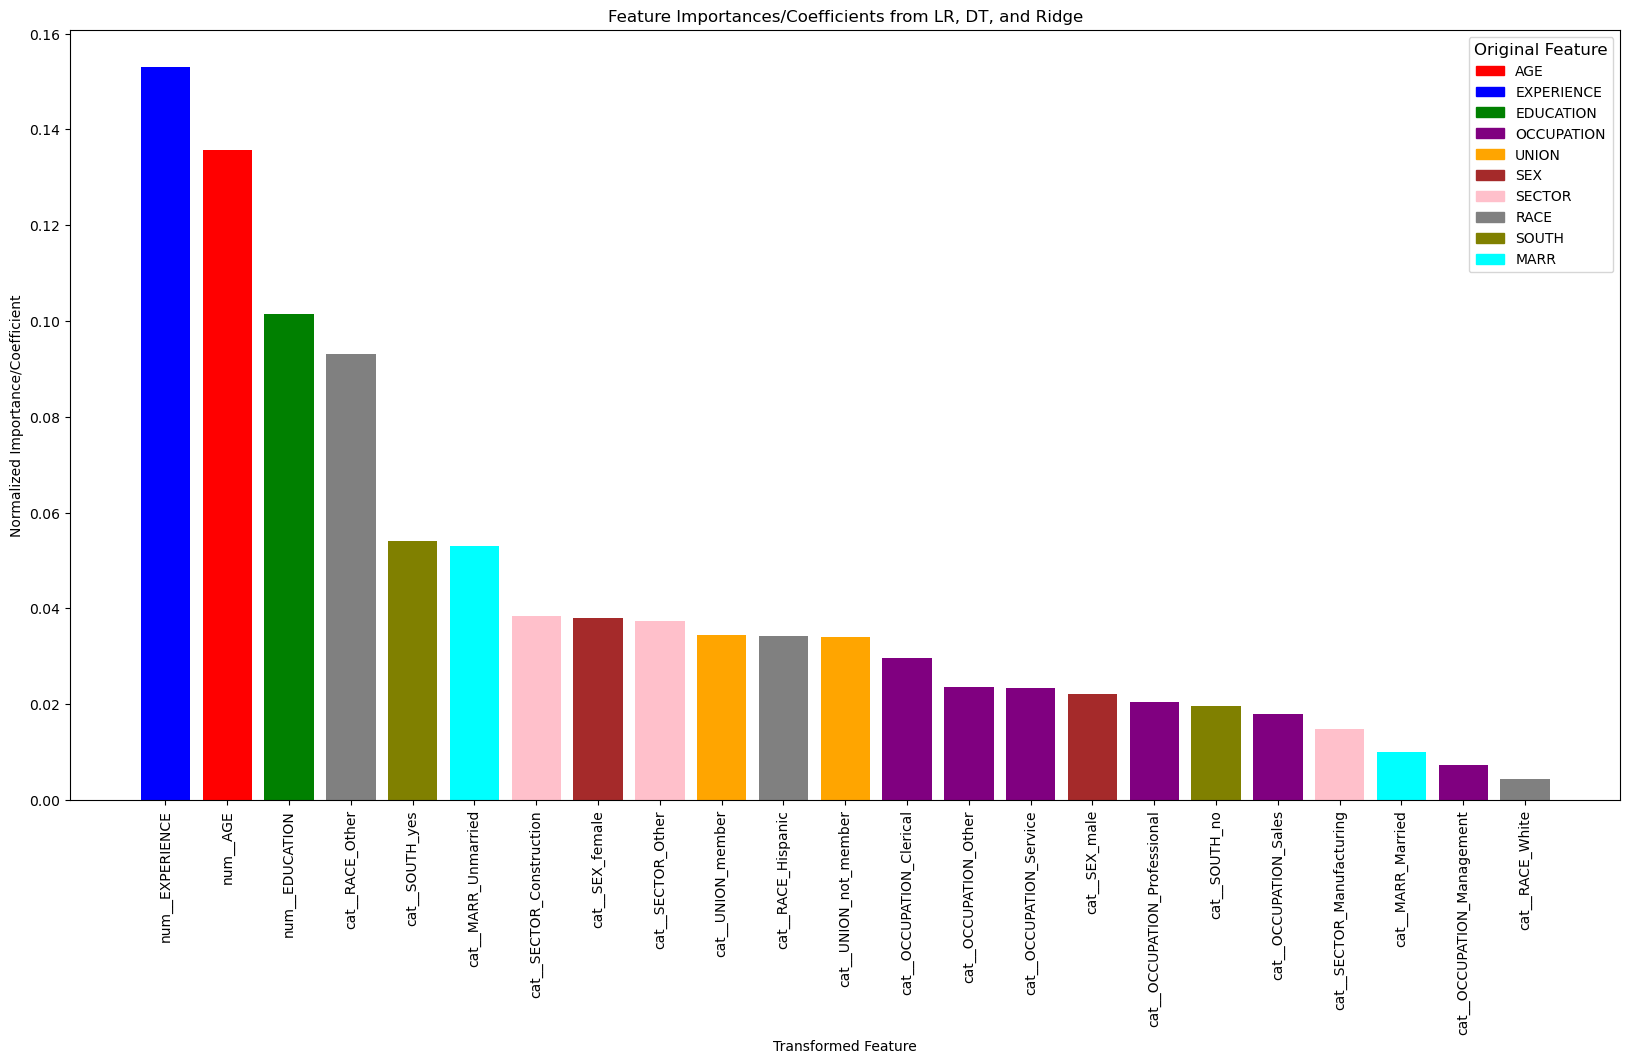

In [177]:
# plot the feature importances sorted in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
transformed_columns = np.array(features)
transformed_columns = transformed_columns[sorted_indices]
feature_importances = feature_importances[sorted_indices]
sorted_colors = np.array(original_colors)[sorted_indices]

plt.figure(figsize=(20, 10))
plt.bar(transformed_columns, feature_importances, color=sorted_colors)
plt.xticks(rotation=90)
plt.title('Feature Importances/Coefficients from LR, DT, and Ridge')
plt.ylabel('Normalized Importance/Coefficient')
plt.xlabel('Transformed Feature')
# add a legend of the original features
handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(handles, color_map.keys(), title='Original Feature', title_fontsize='large')
plt.savefig('./images/feature_importances.png')
plt.show()

In [183]:
# Display the permutation importances
from sklearn.inspection import permutation_importance

# Calculate permutation importance
vote_pipe2.fit(X_train, y_train)
results = permutation_importance(vote_pipe2, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the importances and their standard deviations
importances = results.importances_mean
std_devs = results.importances_std

# Display the permutation importances
for i in range(importances.shape[0]):
    name = X.columns[i]
    print(f"{name}: {importances[i]:.3f} +/- {std_devs[i]:.3f}")

EDUCATION: 0.325 +/- 0.038
SOUTH: 0.009 +/- 0.004
SEX: 0.052 +/- 0.025
EXPERIENCE: 0.049 +/- 0.033
UNION: -0.001 +/- 0.020
AGE: 0.021 +/- 0.006
RACE: 0.005 +/- 0.005
OCCUPATION: 0.119 +/- 0.014
SECTOR: -0.001 +/- 0.009
MARR: 0.001 +/- 0.004


/var/folders/v0/7hny_wjs4tg70rryd7blqpd00000gn/T/ipykernel_50864/2537523467.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X_columns, y=importances, palette=[color_map[extract_original_feature(col)] for col in X_columns])


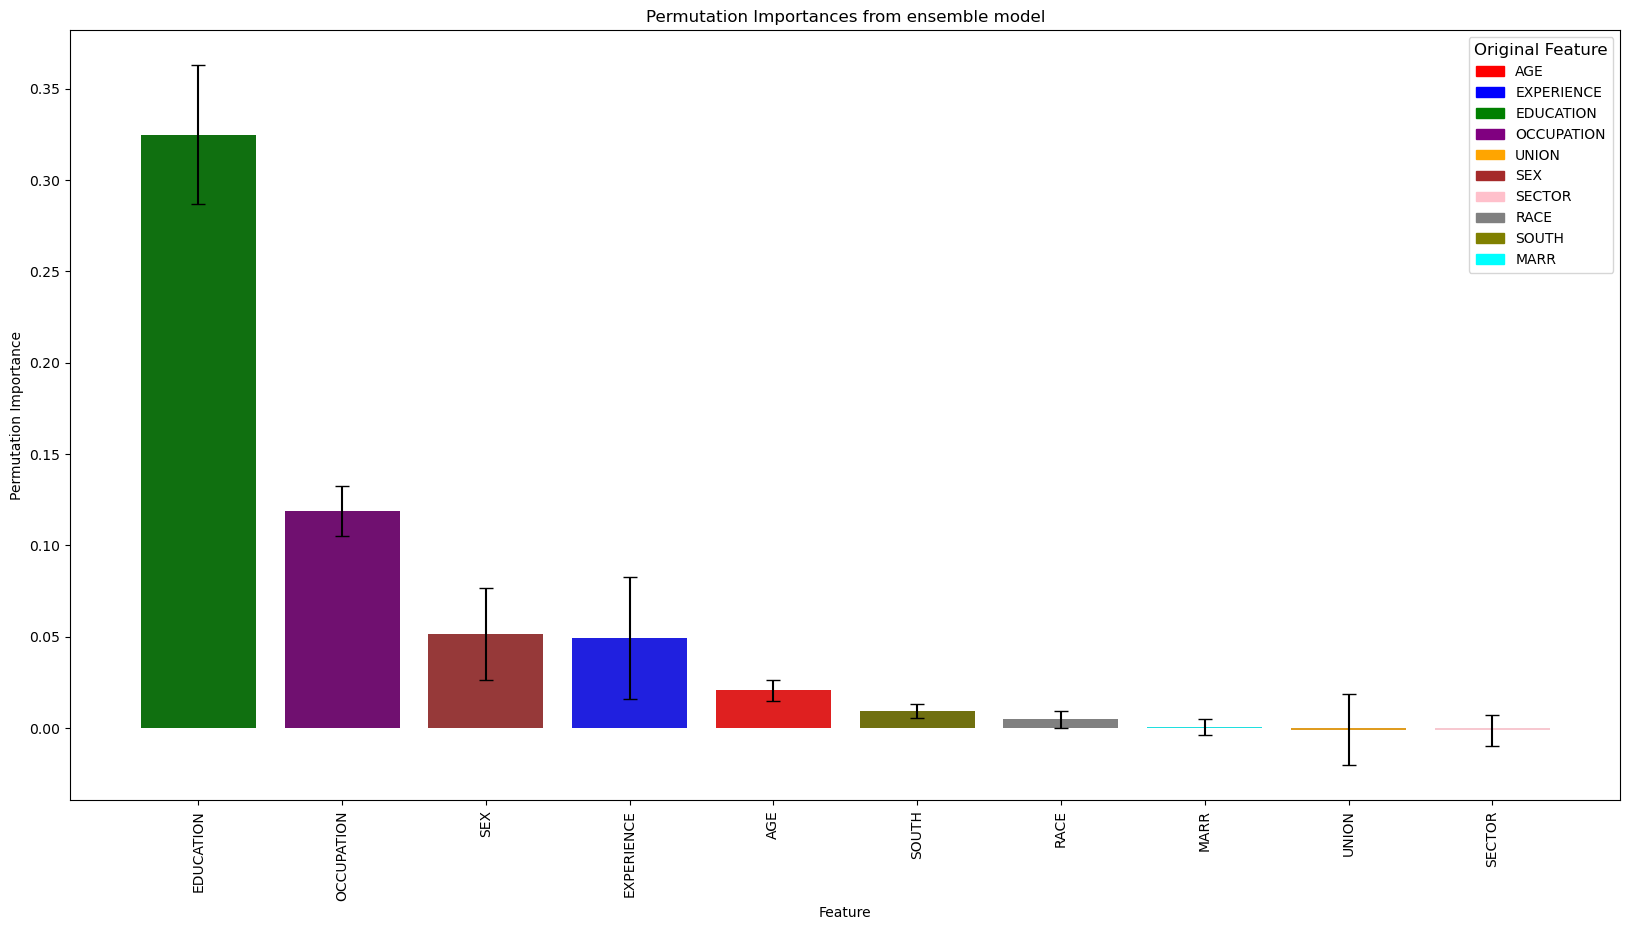

In [184]:
# plot the permutation importances sorted in descending order with their standard deviations using seaborn
import seaborn as sns

sorted_indices = np.argsort(importances)[::-1]
X_columns = X.columns
X_columns = X_columns[sorted_indices]
importances = importances[sorted_indices]
std_devs = std_devs[sorted_indices]

plt.figure(figsize=(20, 10))
# use seaborn to create a bar plot
sns.barplot(x=X_columns, y=importances, palette=[color_map[extract_original_feature(col)] for col in X_columns])
# Add error bars - Note: The errorbar x positions need to be manually set
# Here, we use `range(len(importances))` to align error bars with the bars from seaborn
plt.errorbar(x=range(len(importances)), y=importances, yerr=std_devs, fmt='none', c='black', capsize=5)

plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Permutation Importances from ensemble model')
#add a legend of the original features
handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(handles, color_map.keys(), title='Original Feature', title_fontsize='large')

plt.xticks(rotation=90)
plt.savefig('./images/permutation_importances.png')
plt.show()
